![bse_logo_textminingcourse](https://bse.eu/sites/default/files/bse_logo_small.png)

In [73]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Part 3: Implementation

Following the previous analysis, the team decided to implement the methodology outlined below.

*   The mental health corpus was divided into two distinct datasets:

    - The first dataset comprised individuals labeled as "1: Mentally Ill People."
    - The second dataset consisted of individuals labeled as "0: Healthy People."
    - The process consisted of the following steps:

* Both datasets were split into training and testing sets.
* A dictionary was extracted from each dataset.
* The team then determined a weighting method to adjust word frequency. This was done to identify and potentially discard words from the "Mentally Ill People" dataset that were also frequently present in the "Healthy People" dataset.
* A simple logistic regression model was trained and evaluated to assess the accuracy of the generated dictionaries.

For this implementation the team decided to use lemmatized text instead of stemmed text because its superior accuracy and interpretability.  Lemmatization returns valid dictionary words (lemmas), preserving semantic meaning and grammatical correctness, which is crucial for downstream NLP tasks like sentiment analysis and topic modeling

In [74]:
df = pd.read_csv("data/preprocessing/mental_health_preprocessed.csv")
df.head()

,Unnamed: 0,text,label,text_no_stopwords,text_stem,text_lemma
0,0,dear american teens question dutch person hear...,0,dear american teens question dutch person hear...,dear american teen question dutch person heard...,dear american teen question dutch person hear ...
1,1,nothing look forward lifei dont many reasons k...,1,nothing look forward lifei dont many reasons k...,noth look forward lifei dont mani reason keep ...,look forward lifei not reason going feel like ...
2,2,music recommendations im looking expand playli...,0,music recommendations im looking expand playli...,music recommend im look expand playlist usual ...,music recommendation m look expand playlist us...
3,3,im done trying feel betterthe reason im still ...,1,im done trying feel betterthe reason im still ...,im done tri feel betterth reason im still aliv...,m try feel betterthe reason m alive know mum d...
4,4,worried year old girl subject domestic physic...,1,worried year old girl subject domestic physica...,worri year old girl subject domest physicalmen...,worry year old girl subject domestic physicalm...


## Split the Corpus into Train & Test Sets

In [75]:
from sklearn.model_selection import train_test_split

# Separate texts based on label
texts_0 = df[df["label"] == 0]["text_lemma"].dropna().tolist()  # Healthy group
texts_1 = df[df["label"] == 1]["text_lemma"].dropna().tolist()  # Mentally ill group

# Split dataset into training and testing sets
train_0, test_0 = train_test_split(texts_0, test_size=0.2, random_state=42)
train_1, test_1 = train_test_split(texts_1, test_size=0.2, random_state=42)

# Convert to DataFrame
train_df = pd.DataFrame({"text": train_0 + train_1, "label": [0] * len(train_0) + [1] * len(train_1)})
test_df = pd.DataFrame({"text": test_0 + test_1, "label": [0] * len(test_0) + [1] * len(test_1)})

# Save to CSV for reference
train_df.to_csv("data/training/train_data.csv", index=False)
test_df.to_csv("data/training/test_data.csv", index=False)

print("Training and test sets created successfully.")

Training and test sets created successfully.


## Extract a Dictionary from Each Corpus

In [76]:
# Separate texts based on label
texts_train_0 = train_df[train_df["label"] == 0]["text"].dropna().tolist()
texts_train_1 = train_df[train_df["label"] == 1]["text"].dropna().tolist()

# Apply TF-IDF separately for each group
vectorizer_0 = TfidfVectorizer(stop_words="english", max_features=30)
tfidf_0 = vectorizer_0.fit_transform(texts_train_0)
words_0 = vectorizer_0.get_feature_names_out()
scores_0 = np.asarray(tfidf_0.mean(axis=0)).flatten()

vectorizer_1 = TfidfVectorizer(stop_words="english", max_features=30)
tfidf_1 = vectorizer_1.fit_transform(texts_train_1)
words_1 = vectorizer_1.get_feature_names_out()
scores_1 = np.asarray(tfidf_1.mean(axis=0)).flatten()

# Create DataFrames with extracted words and scores
df_tfidf_0 = pd.DataFrame({"word": words_0, "score": scores_0}).sort_values(by="score", ascending=False)
df_tfidf_1 = pd.DataFrame({"word": words_1, "score": scores_1}).sort_values(by="score", ascending=False)

# Extract dictionary from each corpus using TF-IDF
dictionary_0 = set(df_tfidf_0["word"])  # Healthy words
dictionary_1 = set(df_tfidf_1["word"])  # Mentally ill words

# Save the dictionaries for future use
with open("data/dictionaries/dictionary_healthy.txt", "w") as f:
    f.write("\n".join(dictionary_0))

with open("data/dictionaries/dictionary_mentally_ill.txt", "w") as f:
    f.write("\n".join(dictionary_1))

print("Dictionaries extracted and saved.")

Dictionaries extracted and saved.


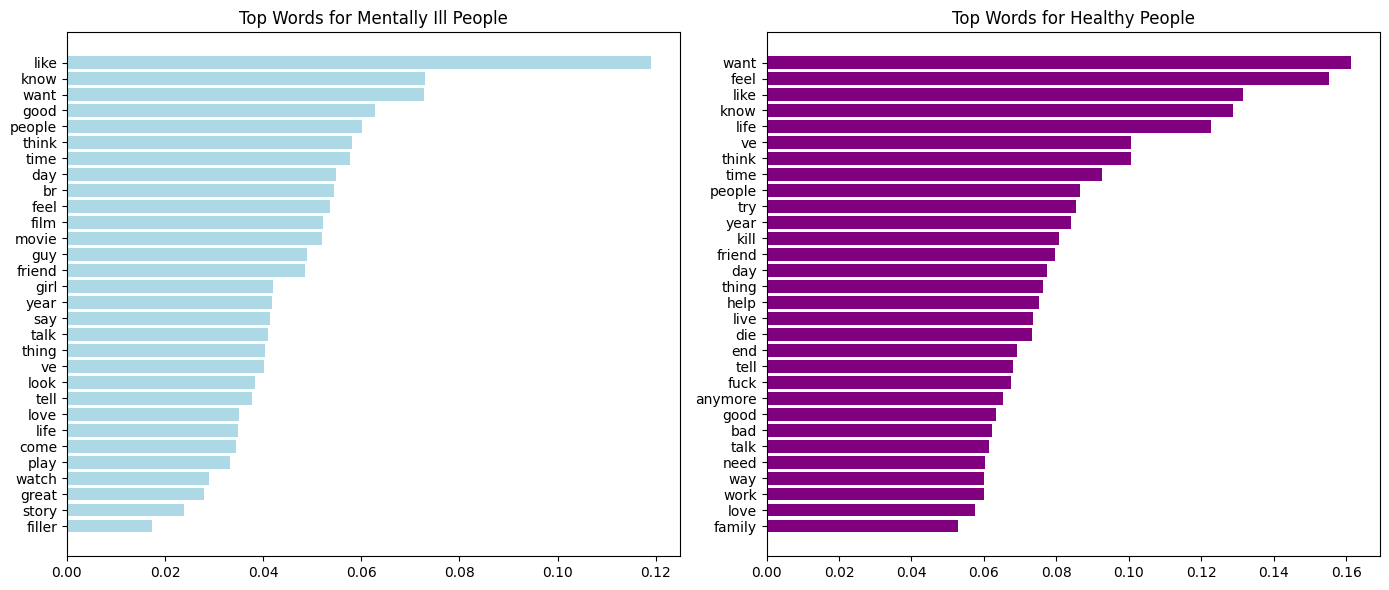

In [77]:
# Plot bar chart for each dictionary
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Mentally Ill People Dictionary
ax[0].barh(df_tfidf_0["word"], df_tfidf_0["score"], color="lightblue")
ax[0].set_title("Top Words for Mentally Ill People")
ax[0].invert_yaxis()

# Healthy People Dictionary
ax[1].barh(df_tfidf_1["word"], df_tfidf_1["score"], color="purple")
ax[1].set_title("Top Words for Healthy People")
ax[1].invert_yaxis()

plt.tight_layout()
plt.show()

This code snippet calculates the relative importance of words in the mentally ill group compared to the healthy group using TF-IDF scores. It then ranks the words by importance, keeps the top 30, and saves them in a file. To adjust the score the following formula is used:

$\text{adjusted score} = \frac{\text{TF-IDF en mentally ill}}{\text{TF-IDF en healthy} + \epsilon}$

In [78]:
# Calculate frequency of words in both classes
word_weights = {}
for word in dictionary_1:
    freq_1 = df_tfidf_1[df_tfidf_1["word"] == word]["score"].values[0] if word in df_tfidf_1["word"].values else 0
    freq_0 = df_tfidf_0[df_tfidf_0["word"] == word]["score"].values[0] if word in df_tfidf_0["word"].values else 0
    word_weights[word] = freq_1 / (freq_0 + 1e-6)  # Avoid division by zero

# Sort words by importance (higher values = more relevant to mentally ill class)
filtered_words = sorted(word_weights.items(), key=lambda x: x[1], reverse=True)[:30]  # Keep top 30 words

# Save filtered dictionary
with open("data/dictionaries/filtered_dictionary.txt", "w") as f:
    f.write("\n".join([word for word, score in filtered_words]))

print("Filtered dictionary generated.")


df_filtered_words = pd.DataFrame(filtered_words, columns=["Word", "Importance Score"])
df_filtered_words

Filtered dictionary generated.


,Word,Importance Score
0,try,85430.850024
1,kill,80732.394717
2,help,75115.802095
3,live,73611.718322
4,die,73238.740831
5,end,69068.974510
6,fuck,67512.827835
7,anymore,65301.134306
8,bad,62129.046782
9,need,60410.815630


Logistic Regression Accuracy: 0.8077
Precision: 0.8110
Recall: 0.7969
F1 Score: 0.8039


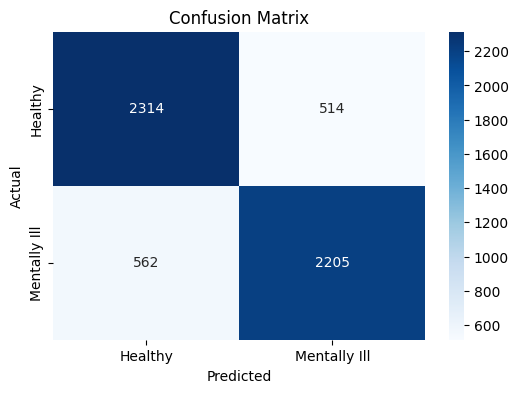

In [79]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score

# Convert train and test text into TF-IDF features using only filtered words
vectorizer = TfidfVectorizer(vocabulary=[word for word, _ in filtered_words])
X_train = vectorizer.fit_transform(train_df["text"])
X_test = vectorizer.transform(test_df["text"])

# Train a logistic regression model
model = LogisticRegression(random_state=42)
model.fit(X_train, train_df["label"])

# Make predictions
y_pred = model.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(test_df["label"], y_pred)
precision = precision_score(test_df["label"], y_pred)
recall = recall_score(test_df["label"], y_pred)
f1 = f1_score(test_df["label"], y_pred)
print(f"Logistic Regression Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion matrix
cm = confusion_matrix(test_df["label"], y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Healthy", "Mentally Ill"], yticklabels=["Healthy", "Mentally Ill"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [80]:
# Classification report
print("Classification Report:")
print(classification_report(test_df["label"], y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81      2828
           1       0.81      0.80      0.80      2767

    accuracy                           0.81      5595
   macro avg       0.81      0.81      0.81      5595
weighted avg       0.81      0.81      0.81      5595



### Load random tuits from X.com

sample_df

In [83]:
import pandas as pd

# Load the test dataset
df_test = pd.read_csv("data/test.csv")

# Select a random sample of 10,000 tweets
sample_df = df_test.sample(n=100000, random_state=42)

# Ensure the tweet data is in string format
sample_df["tweet"] = sample_df["tweet"].astype(str)

# Transform the sample data using the trained vectorizer
X_sample = vectorizer.transform(sample_df["tweet"])

# Apply the trained model to make predictions
predictions = model.predict(X_sample)

# Add the predictions to the DataFrame
sample_df["prediction"] = predictions

# Save the results to a CSV file if needed
sample_df.to_csv("data/predicted_tweets.csv", index=False)

# Display the first results
# Filter only tweets where the prediction label is 1
filtered_df = sample_df[sample_df["prediction"] == 1]

# Show the first few rows of the filtered results
filtered_df




,index,tweet,prediction
26127,575595,"@dana_chosenart haha, thanks. But I don't thin...",1
142931,1268013,@ALauderdale Company and Sushi usually have th...,1
43195,1489378,"@cysticfibrosisM watching NCIS, but do feel a ...",1
3056,690148,@partycrasherxx i will never laugh for you any...,1
85840,474159,"going to bed, i feel so sick! Night xx",1
...,...,...,...
121422,1584846,"I'm waiting for basijis to come and kill me ,...",1
69584,1025661,Apparently Obama thinks Bush set aside princip...,1
1902,190965,So sleepy that I feel reluctant to show up at ...,1
63242,1599615,@brothrsaw The count would lead to shutter dea...,1
